In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [2]:
df = pd.read_csv('datasets/english_pidgin.csv')
df.head()

,English,Pidgin
0,Go.,Go !
1,Go.,Go.
2,Go.,Go!
3,Go.,Go !
4,Hi.,Salot !


In [3]:
df.shape

(229787, 2)

In [7]:
# Separating the English and French datasets
eng = df['English']
pdg = df['Pidgin']

In [8]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1396741
Count of distinct English words: 31934
10 most common English words: ('I', 'to', 'you', 'the', 'a', 'Tom', 'is', 'of', 'that', 'in')


In [10]:
pdg_word_counter = Counter([word for sentence in pdg for word in sentence.split()])
print("Total count of French words:",len([word for sentence in pdg for word in sentence.split()]))
print("Count of distinct French words:",len(pdg_word_counter))
print("10 most common French words:",list(zip(*pdg_word_counter.most_common(10)))[0])

Total count of French words: 1523774
Count of distinct French words: 50958
10 most common French words: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'le', 'la', 'Tom')


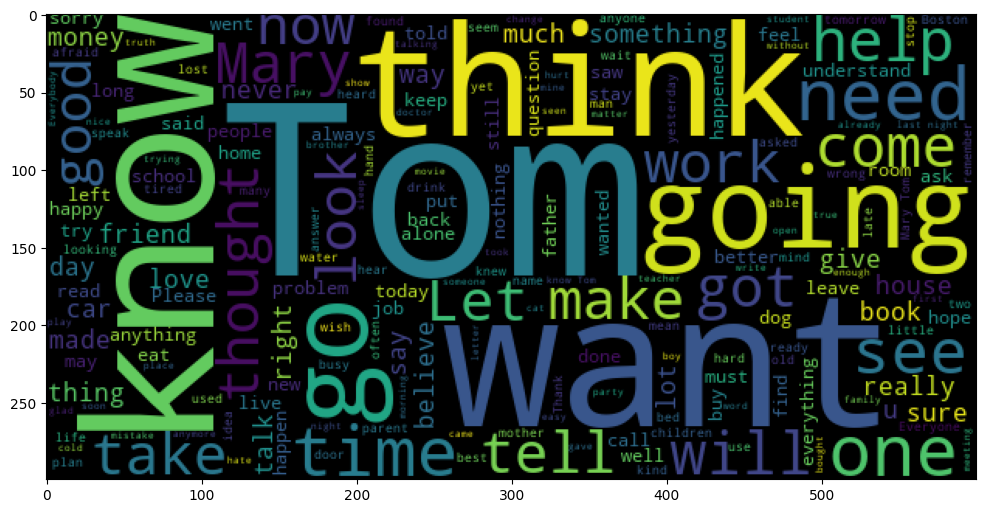

In [11]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

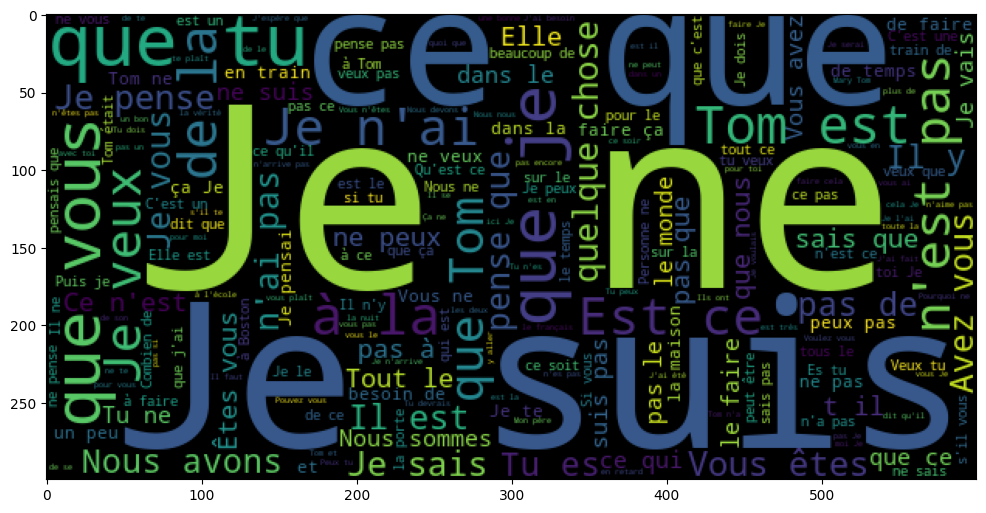

In [12]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(pdg))
plt.imshow(wc)
plt.show();

In [13]:
def word_count(line):
  return len(line.split())

In [15]:
df['English_word_count'] = df['English'].apply(lambda x: word_count(x))
df['Pidgin_word_count'] = df['Pidgin'].apply(lambda x: word_count(x))

/var/folders/51/m56t55qd28b08jwpssntxdyh0000gn/T/ipykernel_10559/3773450394.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['English_word_count'],ax=axes[0])
/var/folders/51/m56t55qd28b08jwpssntxdyh0000gn/T/ipykernel_10559/3773450394.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

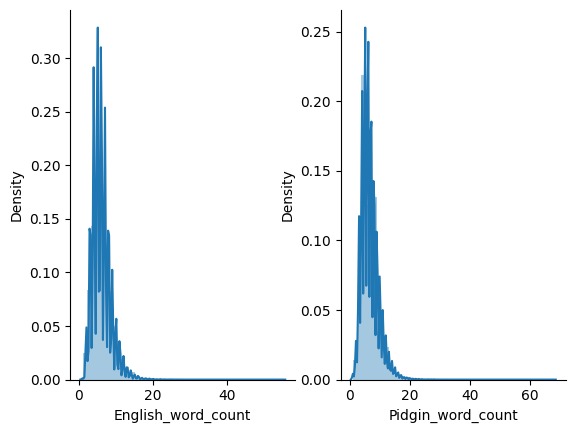

In [17]:
fig, axes = plt.subplots(nrows=1,ncols=2)
sns.distplot(df['English_word_count'],ax=axes[0])
sns.distplot(df['Pidgin_word_count'],ax=axes[1])
sns.despine()
plt.show();

In [18]:
def create_tokenizer(sentences):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  return tokenizer

In [19]:
def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

In [20]:
def encode_sequences(tokenizer,sentences,max_sent_len):
  text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
  text_pad_seq = pad_sequences(text_to_seq,maxlen=max_sent_len,padding='post') # pad sequences with 0
  return text_pad_seq

In [21]:
# Prepare English tokenizer
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_sent_len = max_sentence_length(eng)
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_eng_sent_len)

English vocabulary size: 16632
Maximum length of English sentences: 55


In [23]:
# Prepare French tokenizer
pdg_tokenizer = create_tokenizer(pdg)
pdg_vocab_size = len(pdg_tokenizer.word_index) + 1
max_pdg_sent_len = max_sentence_length(pdg)
print("Pidgin vocabulary size:", pdg_vocab_size)
print("Maximum length of French sentences:", max_pdg_sent_len)

Pidgin vocabulary size: 35087
Maximum length of French sentences: 68


In [24]:
max_eng_sent_len = 22
max_pdg_sent_len = 22

In [25]:
# Perform encoding of sequences
X = encode_sequences(eng_tokenizer,eng,max_eng_sent_len)
y = encode_sequences(pdg_tokenizer,pdg,max_pdg_sent_len)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)

In [27]:
def create_model(src_vocab_size, dest_vocab_size, src_timesteps, dest_timesteps, no_units):
    model = Sequential()
    model.add(Embedding(src_vocab_size, no_units, mask_zero=True))
    model.add(LSTM(no_units))
    model.add(RepeatVector(dest_timesteps))
    model.add(LSTM(no_units, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(dest_vocab_size, activation='softmax')))
    return model

In [29]:
model = create_model(eng_vocab_size,pdg_vocab_size,max_eng_sent_len,max_pdg_sent_len,512)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ repeat_vector_1 (RepeatVector)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_3 (LSTM)                   │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_2              │ ?                         │          0 │
│ (TimeDistributed)               │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_3              │ ?                         │          0 │
│ (TimeDistributed)               │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

In [31]:
es = EarlyStopping(monitor='val_accuracy',patience=5,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [47]:
r = model.fit(X_train,
              y_train.reshape(y_train.shape[0],y_train.shape[1],1),
              epochs=6,
              batch_size=512,
              callbacks=[es,lr],
              validation_data=(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1)))

Epoch 1/6


2024-01-11 15:46:52.727806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 36/292 ━━━━━━━━━━━━━━━━━━━━ 54:39 13s/step - accuracy: 0.6156 - loss: 6.2481

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

In [ ]:
model.save('english_to_french_translator.h5')

In [ ]:
translator_model = load_model('models/english_to_french_translator.h5')
translator_model

In [ ]:
def translate_sentence(sentence, eng_tokenizer, pdg_tokenizer, max_eng_sent_len, max_pdg_sent_len, translator_model):
    # Tokenize and encode the input sentence
    sentence_seq = eng_tokenizer.texts_to_sequences([sentence])
    padded_sentence = pad_sequences(sentence_seq, maxlen=max_eng_sent_len, padding='post')

    # Get the model prediction for the input sentence
    predicted_seq = translator_model.predict(padded_sentence)

    # Decode the predicted sequence into French
    translated_sentence = ''
    for token in predicted_seq[0]:
        sampled_token_index = np.argmax(token)
        if sampled_token_index == 0:
            break
        word = pdg_tokenizer.index_word[sampled_token_index]
        translated_sentence += ' ' + word

    return translated_sentence.strip()

# Example usage:
english_sentence = "Hello how are you?"
translated_sentence = translate_sentence(english_sentence, eng_tokenizer, pdg_tokenizer, max_eng_sent_len, max_pdg_sent_len, translator_model)

print(f"English: {english_sentence}")
print(f"Translated French: {translated_sentence}")
